In [19]:
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

In [20]:
height, width = 224, 224
batch_size=32

In [22]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
training_set_path="C:/Users/18585/Desktop/Summer Research/PSMImageClassifier/DataSet_2/Training"
validation_set_path="C:/Users/18585/Desktop/Summer Research/PSMImageClassifier/DataSet_2/Validation"
testing_set_path="C:/Users/18585/Desktop/Summer Research/PSMImageClassifier/DataSet_2/Testing"

def image_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen.flow_from_directory(
            training_set_path,
            batch_size=batch_size,
            #color_mode = 'grayscale',
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'Positive': 0., 'Negative': 1.}
            )
    val_ds = datagen.flow_from_directory(
              validation_set_path,
              #seed=123,
              #color_mode = 'grayscale',
              class_mode='binary',
              target_size=(height, width),
              batch_size=batch_size,
              classes={'Positive': 0., 'Negative': 1.}
            )
    test_ds = datagen.flow_from_directory(
              testing_set_path,
              class_mode='binary',
              target_size=(height, width),
              batch_size=2,
              classes={'Positive': 0., 'Negative': 1.}
            )
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = image_generator(height,width)

total_image = np.concatenate([train_ds.labels,val_ds.labels, test_ds.labels])
print('\n\n',{'positive':len(np.where(total_image==0)[0]),
      'negative':len(np.where(total_image==1)[0])})

Found 586 images belonging to 2 classes.
Found 101 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


 {'positive': 376, 'negative': 352}


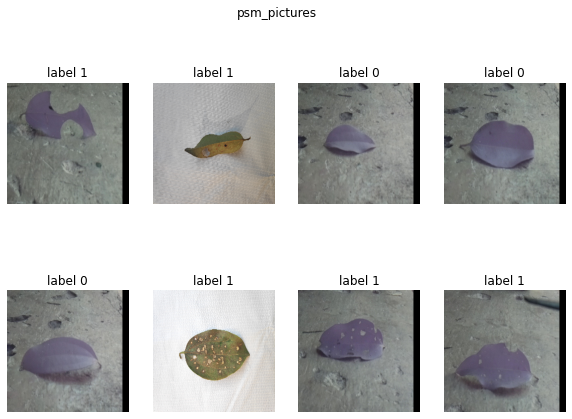

In [23]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("psm_pictures")
for k in range(8):
    images, labels = train_ds.next()
    i, j = k//4, k%4
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()

In [24]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = tf.keras.Sequential()
model_vgg19.add(base_model)
model_vgg19.add(tf.keras.layers.Flatten())

model_vgg19.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vgg19.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_vgg19.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
19/19 [==============================] - ETA: 0s - loss: 6.6916 - acc: 0.5734
Epoch 1: acc improved from -inf to 0.57338, saving model to model\vgg19_best.h5
19/19 [==============================] - 39s 2s/step - loss: 6.6916 - acc: 0.5734 - val_loss: 3.1738 - val_acc: 0.7030
Epoch 2/25
19/19 [==============================] - ETA: 0s - loss: 1.5856 - acc: 0.7628
Epoch 2: acc improved from 0.57338 to 0.76280, saving model to model\vgg19_best.h5
19/19 [==============================] - 37s 2s/step - loss: 1.5856 - acc: 0.7628 - val_loss: 0.1885 - val_acc: 0.9604
Epoch 3/25
19/19 [==============================] - ETA: 0s - loss: 0.7322 - acc: 0.8174
Epoch 3: acc improved from 0.76280 to 0.81741, saving model to model\vgg19_best.h5
19/19 [==============================] - 38s 2s/step - loss: 0.7322 - acc: 0.8174 - val_loss: 0.3147 - val_acc: 0.9406
Epoch 4/25
19/19 [==============================] - ETA: 0s - loss: 0.4300 - acc: 0.8686
Epoch 4: acc improved from 0.81741 to 0.8

In [26]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

4/4 [==============================] - 6s 1s/step - loss: 0.0042 - acc: 1.0000


,Train,Val
Loss,0.013183,0.00415
Acc,1.000000,1.00000


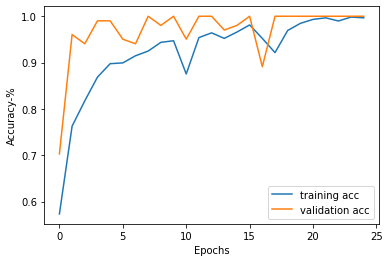

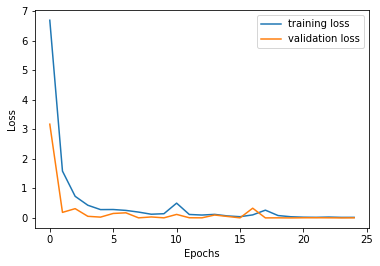

In [27]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [28]:
def augmentataion_generator(height,width):
    datagen = ImageDataGenerator(
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            rotation_range=30,
            horizontal_flip=True,
            brightness_range=(0.5, 1.0)
            )
    aug_train_ds = datagen.flow_from_directory(
            training_set_path,
            batch_size=64,
            shuffle=True,
            class_mode='binary',
            target_size=(height, width),
            classes={'positive': 0., 'negative': 1.}
            )
    return aug_train_ds
aug_train_ds = augmentataion_generator(height,width)

Found 586 images belonging to 2 classes.


In [29]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,reduce_lr]

history = model_vgg19.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 1.6677 - acc: 0.6365
Epoch 1: acc did not improve from 0.99829
10/10 [==============================] - 41s 4s/step - loss: 1.6677 - acc: 0.6365 - val_loss: 0.0049 - val_acc: 1.0000 - lr: 0.0100
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 1.1338 - acc: 0.7184
Epoch 2: acc did not improve from 0.99829
10/10 [==============================] - 40s 4s/step - loss: 1.1338 - acc: 0.7184 - val_loss: 0.0682 - val_acc: 0.9604 - lr: 0.0100
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 1.7946 - acc: 0.6775
Epoch 3: acc did not improve from 0.99829
10/10 [==============================] - 41s 4s/step - loss: 1.7946 - acc: 0.6775 - val_loss: 0.1020 - val_acc: 0.9703 - lr: 0.0100
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 1.9951 - acc: 0.6962
Epoch 4: acc did not improve from 0.99829
10/10 [==============================] - 41s 4s/step - loss: 1.9951 - acc: 0.696

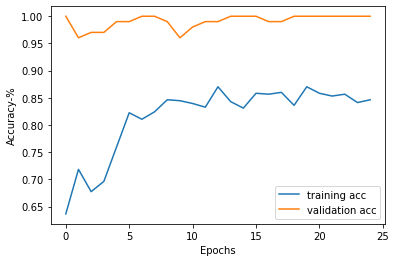

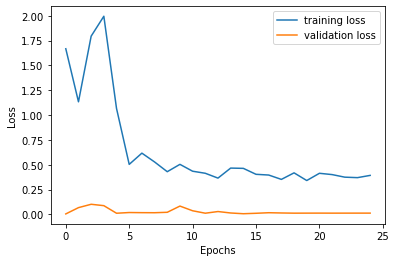

In [30]:
plot_learning_curve(history)

In [31]:
train_result = model_vgg19.evaluate(train_ds)
val_result = model_vgg19.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

4/4 [==============================] - 6s 1s/step - loss: 0.0129 - acc: 1.0000


,Train,Val
Loss,0.036718,0.012888
Acc,0.991468,1.000000


In [32]:
ypred_val = model_vgg19.predict(val_ds[0][0])
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])
y_val = val_ds[0][-1]

print(confusion_matrix(y_val, ypred_val))
print('\n',classification_report(ypred_val,y_val))

1/1 [==============================] - 2s 2s/step
[[14  0]
 [ 0 18]]

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        18

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [35]:
height = 299
width = 299

train_ds, val_ds, test_ds = image_generator(height,width)

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

Found 586 images belonging to 2 classes.
Found 101 images belonging to 2 classes.
Found 41 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 21,933,857
Trainable params: 131,073
Non-trainable params: 21,802,784
_________________________________________________________________


In [36]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25
19/19 [==============================] - ETA: 0s - loss: 2.0445 - acc: 0.7730
Epoch 1: acc improved from -inf to 0.77304, saving model to model\inceptionv3_best.h5
19/19 [==============================] - 26s 1s/step - loss: 2.0445 - acc: 0.7730 - val_loss: 0.1987 - val_acc: 0.9703
Epoch 2/25
19/19 [==============================] - ETA: 0s - loss: 1.1312 - acc: 0.8908
Epoch 2: acc improved from 0.77304 to 0.89078, saving model to model\inceptionv3_best.h5
19/19 [==============================] - 22s 1s/step - loss: 1.1312 - acc: 0.8908 - val_loss: 0.2315 - val_acc: 0.9604
Epoch 3/25
19/19 [==============================] - ETA: 0s - loss: 0.5134 - acc: 0.9334
Epoch 3: acc improved from 0.89078 to 0.93345, saving model to model\inceptionv3_best.h5
19/19 [==============================] - 22s 1s/step - loss: 0.5134 - acc: 0.9334 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 4/25
19/19 [==============================] - ETA: 0s - loss: 0.1455 - acc: 0.9727
Epoch 4: acc improved f

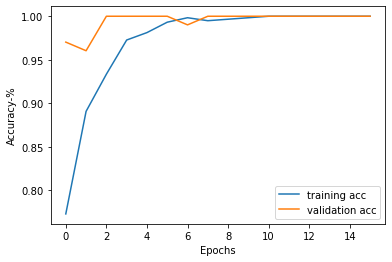

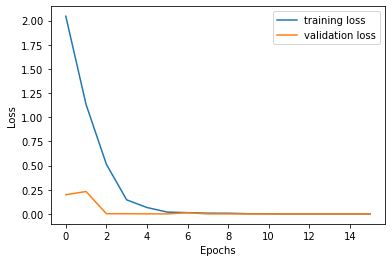

In [37]:
plot_learning_curve(history)

In [38]:
aug_train_ds = augmentataion_generator(height,width)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', factor=0.3,
                              patience=3, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=25, 
        #shuffle=True, 
        verbose=True,
        callbacks=callbacks_list)

Found 586 images belonging to 2 classes.
Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 1.3773 - acc: 0.8515
Epoch 1: acc did not improve from 1.00000
10/10 [==============================] - 30s 3s/step - loss: 1.3773 - acc: 0.8515 - val_loss: 0.1224 - val_acc: 0.9307 - lr: 0.0010
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 1.6185 - acc: 0.8328
Epoch 2: acc did not improve from 1.00000
10/10 [==============================] - 29s 3s/step - loss: 1.6185 - acc: 0.8328 - val_loss: 0.0713 - val_acc: 0.9703 - lr: 0.0010
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 2.2475 - acc: 0.8464
Epoch 3: acc did not improve from 1.00000
10/10 [==============================] - 29s 3s/step - loss: 2.2475 - acc: 0.8464 - val_loss: 0.0319 - val_acc: 0.9901 - lr: 0.0010
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 1.8884 - acc: 0.8498
Epoch 4: acc did not improve from 1.00000
10/10 [==============================] 

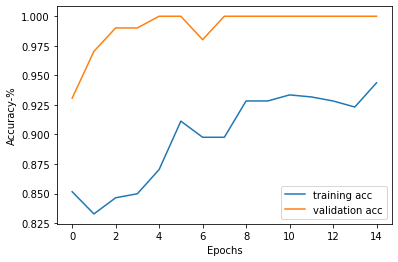

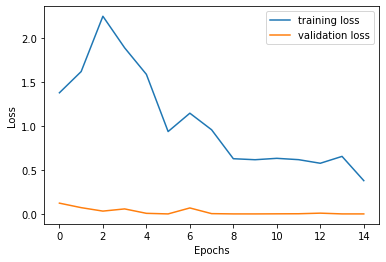

In [39]:
plot_learning_curve(history)

In [40]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

4/4 [==============================] - 4s 701ms/step - loss: 3.3655e-06 - acc: 1.0000


,Train,Val
Loss,0.052300,0.000003
Acc,0.988055,1.000000


In [41]:
ypred = model_inceptionv3.predict(val_ds[0][0])
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
ytest = val_ds[0][-1]

print('Confusion_Matrix:\n',confusion_matrix(ytest, ypred))
print('\nClassification_report:\n',classification_report(ypred,ytest))

1/1 [==============================] - 1s 1s/step
Confusion_Matrix:
 [[16  0]
 [ 0 16]]

Classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        16

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [42]:
test_result = model_inceptionv3.evaluate(test_ds)

21/21 [==============================] - 2s 113ms/step - loss: 1.1294 - acc: 0.8780
